# HA 2 - Birds

In [1]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xa
import matplotlib.pyplot as plt
import json
from typing import *
az.style.use("arviz-white")

You run some bird platform and experiment with recommender and censorship systems.

Improving recommendations or censorship leads to 

* higher/lower recommendation engagement (**people follow the thread**)
* higher/lower **reading time** (the spend more time reading threads)
* There are **like buttons** people tap to further engage

Some historical background stuff

* Historical recommendation engagement **5%**
* Historical reading time is **Exponential** with historical average reading time 1m (60s)
* **40%** topicstarters are liked

```
impression -> 5% -> read thread ~ Exponential(1/60) -> 40% -> like
           \-> 95% -> scrolls                       \-> 60% did not like
```

You've discussed the possble intervals of the outcomes long time ago and they are the following:

* **+/- 3.5%** change for thread read for the experiments, **except for the D**. For D you considered **+/- 5%**, because it touched sensible censorship topic
* **+/- 3%** for the reading time which was similar across the experiments
* **+/- 1.5%** for all the likes related metrics.

**All are RELATIVE**

* **+/- 3%** relative change is considered significant enough

Grading (total 40)
1. Model: 8pt
    1. Implement the model (2pt)
    2. Display the model structure (2pt)
    3. Sample from it, should have 0 divergences (2pt)
    4. Plot az.forest_plot with rope (2pt)
2. Decision Making: 
    * 8 cases, 4pt each
    * Each plot has to be commented
3. No bonus points this time

In [2]:
data = json.load(open("data.json", "r"))

In [3]:
exp = list(data.keys())
pt_base = 0.05
pt_uplift = np.array([0.035, 0.035, 0.035, 0.05]) * pt_base
avg_base = 60
avg_uplift = np.array([0.03] * 4) * avg_base
pl_base = 0.4
pl_uplift = np.array([0.015] * 4) * pl_base

In [4]:
with pm.Model() as model:
    for i in range(len(exp)) :
        idx = exp[i]
        
        pt = pm.Beta(f'pt_{idx}', mu=pt_base, sigma=pt_uplift[i])
        avg = pm.Gamma(f'avg_{idx}', mu=avg_base, sigma=avg_uplift[i])
        pl = pm.Beta(f'pl_{idx}', mu=pl_base, sigma=pl_uplift[i])
        
        sN = pm.Binomial(f'sN_{idx}', n=data[idx]['N'], p=pt, observed=data[idx]['sN'])        
        read = pm.Exponential(f'read_{idx}', lam=1/avg, observed=data[idx]['reads'])        
        like = pm.Binomial(f'like_{idx}', n=sN, p=pl, observed=data[idx]['likes'])
        
        uplift_pt_rel = pm.Deterministic(f'uplift_pt_rel_{idx}', pt / pt_base - 1)
        uplift_avg_rel = pm.Deterministic(f'uplift_avg_rel_{idx}', avg / avg_base - 1)
        uplift_pl_rel = pm.Deterministic(f'uplift_pl_rel_{idx}', pl / pl_base - 1)
        
        uplift_pt_abs = pm.Deterministic(f'uplift_pt_{idx}', pt - pt_base)
        uplift_avg_abs = pm.Deterministic(f'uplift_avg_{idx}', avg - avg_base)
        uplift_pl_abs = pm.Deterministic(f'uplift_pl_{idx}', pl - pl_base)

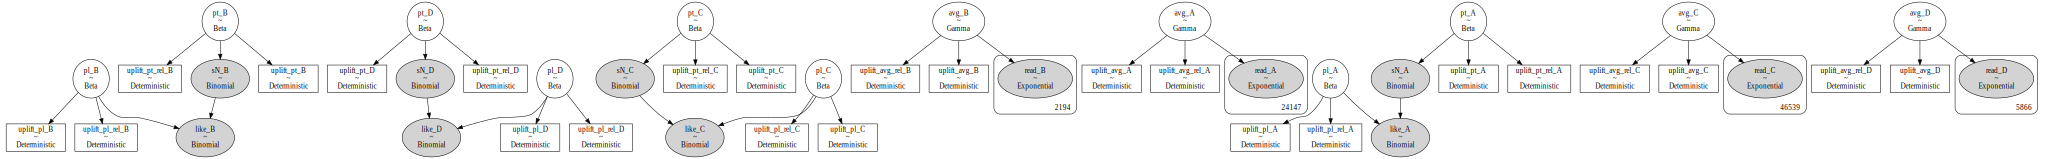

In [5]:
pm.model_to_graphviz(model)

In [6]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pt_A, avg_A, pl_A, pt_B, avg_B, pl_B, pt_C, avg_C, pl_C, pt_D, avg_D, pl_D]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.


**What is the best experiment?**

1. Try to answer just looking onto the rope plot...

In [7]:
pt = xa.concat([trace.posterior["pt_"+idx] for idx in exp], pd.Index(exp, name="exp")).rename("pt")
avg = xa.concat([trace.posterior["avg_"+idx] for idx in exp], pd.Index(exp, name="exp")).rename("avg")
pl = xa.concat([trace.posterior["pl_"+idx] for idx in exp], pd.Index(exp, name="exp")).rename("pl")

uplift_pt = xa.concat([trace.posterior["uplift_pt_"+idx] for idx in exp], pd.Index(exp, name="exp")).rename("uplift_pt")
uplift_avg = xa.concat([trace.posterior["uplift_avg_"+idx] for idx in exp], pd.Index(exp, name="exp")).rename("uplift_avg")
uplift_pl = xa.concat([trace.posterior["uplift_pl_"+idx] for idx in exp], pd.Index(exp, name="exp")).rename("uplift_pl")

uplift_pt_rel = xa.concat([trace.posterior["uplift_pt_rel_"+idx] for idx in exp], pd.Index(exp, name="exp")).rename("uplift_pt_rel")
uplift_avg_rel = xa.concat([trace.posterior["uplift_avg_rel_"+idx] for idx in exp], pd.Index(exp, name="exp")).rename("uplift_avg_rel")
uplift_pl_rel = xa.concat([trace.posterior["uplift_pl_rel_"+idx] for idx in exp], pd.Index(exp, name="exp")).rename("uplift_pl_rel")

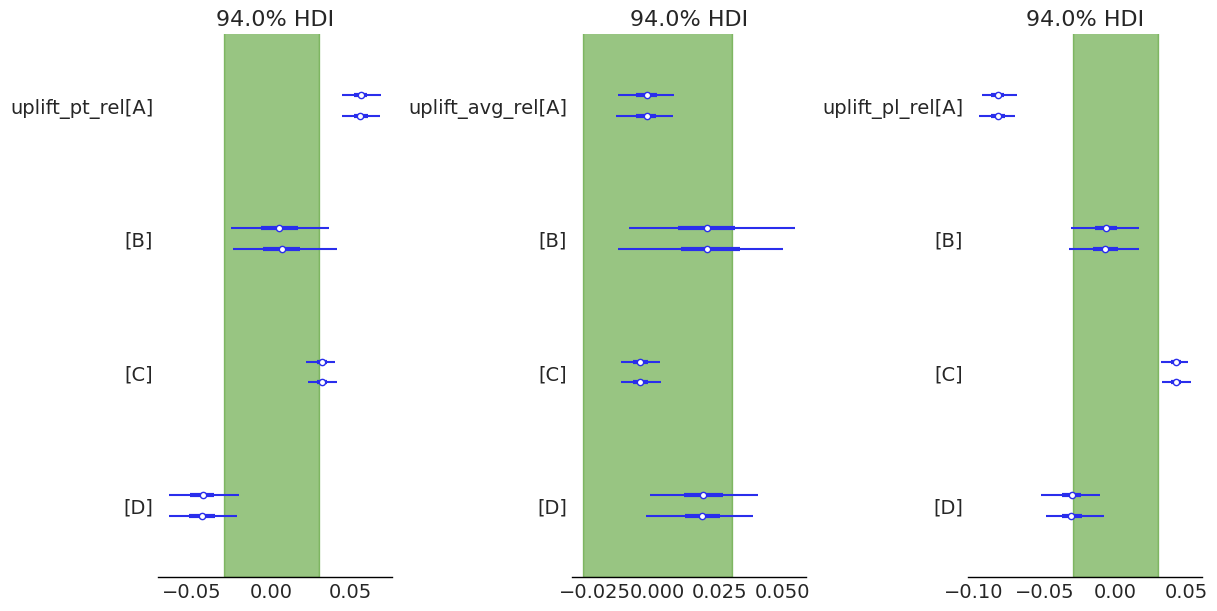

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12,6))
az.plot_forest(uplift_pt_rel, rope=[-0.03, 0.03], ax=ax[0]);
az.plot_forest(uplift_avg_rel, rope=[-0.03, 0.03], ax=ax[1]);
az.plot_forest(uplift_pl_rel, rope=[-0.03, 0.03], ax=ax[2]);

Апостериорное распределение показывает, что эксперимент A значимо увеличивает конверсию по кликам (больше людей открывают статьи из рекомендаций), с другой стороны он значимо снижает конверсию по лайкам. Эксперимент B оказывает скорее незначимое влияние на все 3 метрики. Эксперимент C увеличивает долю кликов примерно более чем в половине случаев, при этом значимо влияет на лайки и незначимо на время прочтения. Эксперимент D скорее отрицательно влияет на клики и лайки и незначимо влияет на время прочтения.

2. Experiment that maximizes likes *after a recommendation*

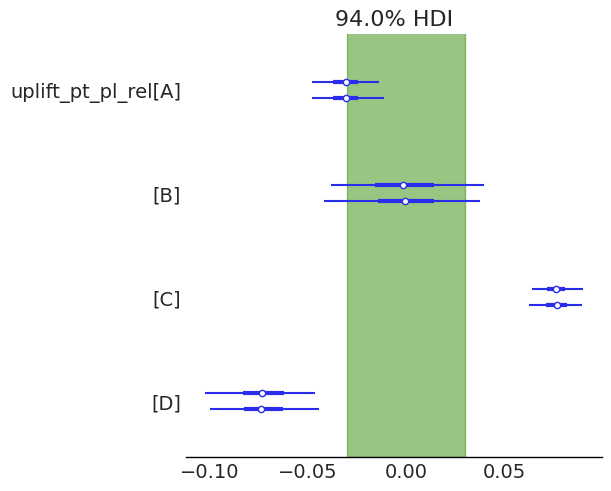

In [9]:
az.plot_forest(((pt * pl) / (pt_base * pl_base) - 1).rename("uplift_pt_pl_rel"), rope=np.array([-0.03,0.03]));

Долю лайков после клика на рекомендованную страницу максимизирует эксперимент C, который значимо и положительно влияет на эту метрику. Эксперимент A в половине случаев отрицательно влияет на лайки после клика, в другой половине эффект незначим. Эксперимент B в целом незначимо влияет на эту метрику, а эксперимент D имеет значимый отрицательный эффект.

3. Experiment that maximized read time *after a recommendation*

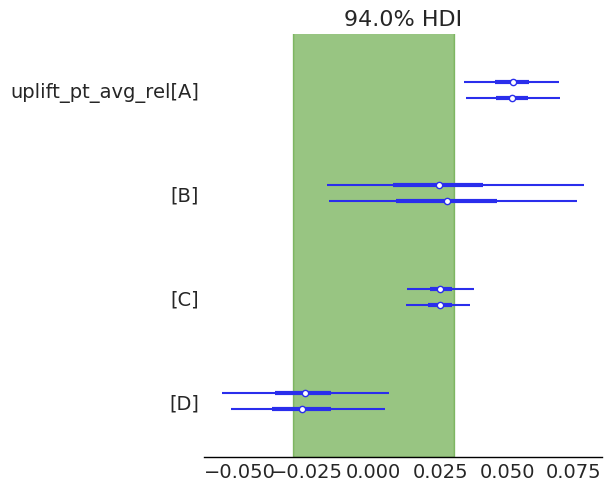

In [10]:
az.plot_forest(((pt * avg) / (pt_base * avg_base) - 1).rename("uplift_pt_avg_rel"), rope=np.array([-0.03,0.03]));

На время прочтения после клика сильнее всего в положительную сторону влияет эксперимент A. Эксперимент B чуть меньше чем в половине случаев значимо увеличивает эту метрику, C меньше чем в трети случаев. Эксперимент D в менее половины случаев снижает время прочтения после клика.

4. Consider valuing (all at once)
    1. each thread follow up with \$0.005
    2. each read second with \$0.0005
    3. each like with \$0.0015
    4. N users = 100000000

In [11]:
def monetization_estimate(
    pt, avg, pl, pt_base, avg_base, pl_base,
    thread_inc, read_inc, like_inc,
    implementation_cost,
    num_users
):
    return (
        (num_users * (pt-pt_base) * thread_inc + num_users * (pt*avg-pt_base*avg_base) * read_inc + num_users * (pt*pl-pt_base*pl_base) * like_inc) - implementation_cost
    )

In [12]:
same_cost_outcomes = monetization_estimate(
    pt=pt, avg=avg, pl=pl, pt_base=pt_base, avg_base=avg_base, pl_base=pl_base,
    thread_inc=0.005, read_inc=0.0005, like_inc=0.0015,
    implementation_cost=0,
    num_users=100000000
).rename("same_cost_outcomes")

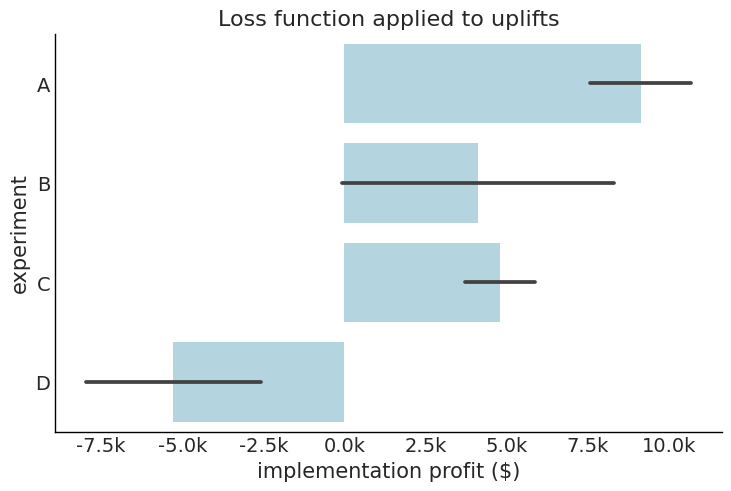

In [13]:
from matplotlib.ticker import FuncFormatter
ax = sns.barplot(
    y="exp",
    x="same_cost_outcomes",
    data=same_cost_outcomes.to_dataframe()["same_cost_outcomes"].reset_index(),
    errorbar="sd",
    color='lightblue',
)
ax.xaxis.set_major_formatter(FuncFormatter(lambda s, a: f"{s/1000}k"))
plt.xlabel("implementation profit ($)")
plt.ylabel("experiment")
plt.title("Loss function applied to uplifts");

Без учета издержек на внедрение наиболее выгодным является вариант A, затем идет вариант C, затем B. Вариант D не приносит денег даже без учета издержек.

5. Consider implementation costs for projects and the previous information
    1. 30000
    2. 20000
    3. 15000
    4. 10000

**Я разделил все издержки на 10.**

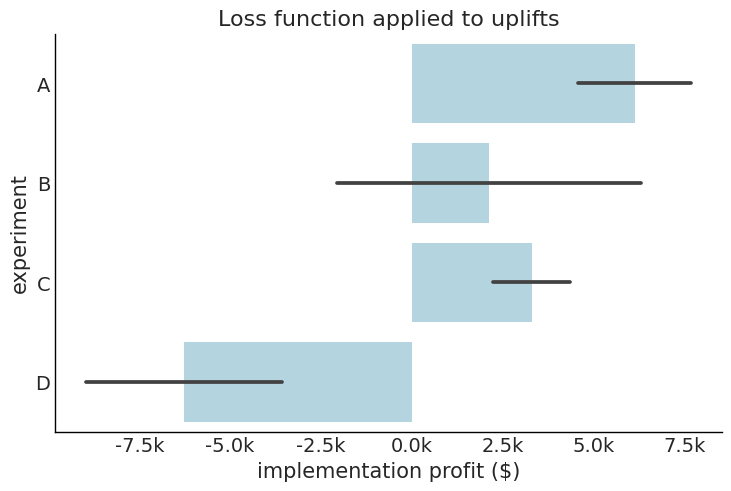

In [14]:
var_costs = xa.DataArray(
    np.array([30000, 20000, 15000, 10000])/10,
   coords=dict(exp=["A", "B", "C", "D"])
)

var_costs_outcomes = monetization_estimate(
    pt=pt, avg=avg, pl=pl, pt_base=pt_base, avg_base=avg_base, pl_base=pl_base,
    thread_inc=0.005, read_inc=0.0005, like_inc=0.0015,
    implementation_cost=var_costs,
    num_users=100000000
).rename("var_costs_outcomes")

from matplotlib.ticker import FuncFormatter
ax = sns.barplot(
    y="exp",
    x="var_costs_outcomes",
    data=var_costs_outcomes.to_dataframe()["var_costs_outcomes"].reset_index(),
    errorbar="sd",
    color='lightblue',
)
ax.xaxis.set_major_formatter(FuncFormatter(lambda s, a: f"{s/1000}k"))
plt.xlabel("implementation profit ($)")
plt.ylabel("experiment")
plt.title("Loss function applied to uplifts");

С учетом издержек вариант A остается наиболее выгодным в базовом сценарии, даже несмотря на наибольшие издержки внедрения. По выгодности варианты располагаются в том же порядке, что и без учета издержек. Стоит отметить, что в варианте B наибольшая неопределенность относительно прибыли, однако он уверенно прибыльнее варианта D.

6. You are going to face people transitioning to another platform. Overall future engagement is quite unsure. Here are scenarios you consider:
    1. Optimistic: there will be bright future, people will visit the app 5\% more frequently
    2. Conservative: nothing will change
    3. Pessimistic: thought leaders will move to the new platform and take 5\% of the audience implementation costs are 50% more
    4. Depression: thought leaders will move to the new platform and take 15\% of the audience implementation costs are 7 times more

In [15]:
users_scenario =  xa.DataArray(
    np.array([1.05, 1, 0.95, 0.85])*100000000,
   coords=dict(scenario=["Optimistic", "Conservative", "Pessimistic", "Depression"])
)
costs_scenario =  xa.DataArray(
    np.array([1, 1, 1.5, 7]),
   coords=dict(scenario=["Optimistic", "Conservative", "Pessimistic", "Depression"])
)

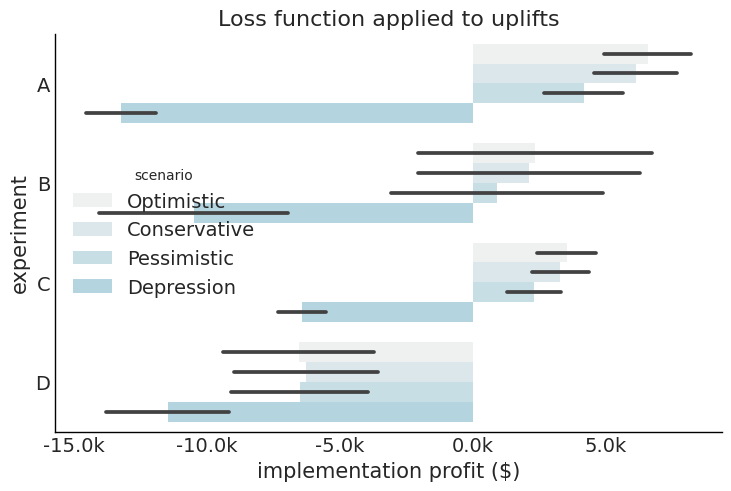

In [16]:
scenario_outcomes = monetization_estimate(
    pt=pt, avg=avg, pl=pl, pt_base=pt_base, avg_base=avg_base, pl_base=pl_base,
    thread_inc=0.005, read_inc=0.0005, like_inc=0.0015,
    implementation_cost=costs_scenario * var_costs,
    num_users=users_scenario
).rename("scenario_outcomes")

from matplotlib.ticker import FuncFormatter
ax = sns.barplot(
    y="exp",
    x="scenario_outcomes",
    hue="scenario",
    data=scenario_outcomes.to_dataframe()["scenario_outcomes"].reset_index(),
    errorbar="sd",
    color='lightblue',
)
ax.xaxis.set_major_formatter(FuncFormatter(lambda s, a: f"{s/1000}k"))
plt.xlabel("implementation profit ($)")
plt.ylabel("experiment")
plt.title("Loss function applied to uplifts");

По первым 3 сценариям выигрывает вариант А. Однако в случае депрессивного сценария издержки внедрения возрастают в 7 раз, а они у варианта А наибольшие, поэтому при данном сценарии А проигрывает всем остальным вариантам. Вариант С является наиболее выгодным (наименее убыточным) при депрессивном сценарии. Вариант В не является предпочтительным при любом сценарии, при этом высокая неопределенность сохраняется. Вариант D остается убыточным при любом сценарии.

7. Among the scenarios, find the probability of being the best among the experiments. Show the heatmap; **Mind the x/y ticks, make sure it is not messed up**


In [17]:
def exp_beats_all(outcomes, exp):
    return (outcomes.sel(exp=exp) > outcomes.drop_sel(exp=exp).max("exp")).mean(["chain", "draw"])

def all_beats_all(outcomes):
    return xa.concat(
        [exp_beats_all(outcomes=outcomes, exp=e) 
         for e in outcomes.coords["exp"].values], dim=outcomes.coords["exp"]
    )

In [18]:
scenario_outcomes_beats_all = all_beats_all(scenario_outcomes)
display(scenario_outcomes_beats_all)
display(scenario_outcomes_beats_all.sel(exp="B"))

<xarray.DataArray 'scenario_outcomes' (exp: 4, scenario: 4)>
array([[0.7745, 0.7685, 0.6865, 0.    ],
       [0.1825, 0.1845, 0.213 , 0.1325],
       [0.043 , 0.047 , 0.1005, 0.848 ],
       [0.    , 0.    , 0.    , 0.0195]])
Coordinates:
  * scenario  (scenario) <U12 'Optimistic' 'Conservative' ... 'Depression'
  * exp       (exp) object 'A' 'B' 'C' 'D'

<xarray.DataArray 'scenario_outcomes' (scenario: 4)>
array([0.1825, 0.1845, 0.213 , 0.1325])
Coordinates:
  * scenario  (scenario) <U12 'Optimistic' 'Conservative' ... 'Depression'
    exp       <U1 'B'

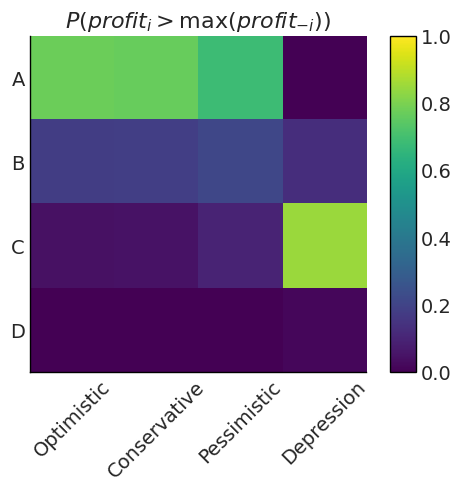

In [19]:
plt.imshow(scenario_outcomes_beats_all, vmin=0, vmax=1)
plt.title(r"$P({profit}_i > \max({profit}_{-i}))$");
plt.yticks(*zip(*enumerate(scenario_outcomes_beats_all.coords["exp"].values)))
plt.xticks(*zip(*enumerate(scenario_outcomes_beats_all.coords["scenario"].values)), rotation=45)
plt.colorbar();

Наибольшей вероятностью быть лучшим при первыъ 3 сценариях является вариант А (вероятность > 70%). Следом идет вариант B с вероятностью около 20%. При депрессивном сценарии выигрывает вариант C с вероятностью 83% быть наилучшим. За ним идет вариант B с 15%. Несмотря на высокую неопределенность, вариант B занимает 2 место в порядке предпочтения по вероятности при любом сценарии. Вероятность быть наилучшим у варианта D равна или близка к 0 при всех сценариях.

8. You have to be conservative in the decision, find the 5% lower quantile for each experiment and scenario, show it on the heatmap, center it around zero. **Mind the x/y ticks, make sure it is not messed up**

In [20]:
scenario_quantile = np.round(scenario_outcomes.quantile(q=0.05, dim=["chain", "draw"]), 2)
display(scenario_quantile)
display(scenario_quantile.sel(exp="C"))

<xarray.DataArray 'scenario_outcomes' (scenario: 4, exp: 4)>
array([[  4002.01,  -4775.03,   1710.4 , -11160.2 ],
       [  3668.58,  -4642.89,   1557.52, -10676.39],
       [  1835.15,  -5510.75,    654.65, -10692.57],
       [-15331.71, -16246.46,  -7901.1 , -15224.93]])
Coordinates:
  * scenario  (scenario) <U12 'Optimistic' 'Conservative' ... 'Depression'
  * exp       (exp) object 'A' 'B' 'C' 'D'
    quantile  float64 0.05

<xarray.DataArray 'scenario_outcomes' (scenario: 4)>
array([ 1710.4 ,  1557.52,   654.65, -7901.1 ])
Coordinates:
  * scenario  (scenario) <U12 'Optimistic' 'Conservative' ... 'Depression'
    exp       <U1 'C'
    quantile  float64 0.05

In [21]:
display(scenario_quantile.T)

<xarray.DataArray 'scenario_outcomes' (exp: 4, scenario: 4)>
array([[  4002.01,   3668.58,   1835.15, -15331.71],
       [ -4775.03,  -4642.89,  -5510.75, -16246.46],
       [  1710.4 ,   1557.52,    654.65,  -7901.1 ],
       [-11160.2 , -10676.39, -10692.57, -15224.93]])
Coordinates:
  * scenario  (scenario) <U12 'Optimistic' 'Conservative' ... 'Depression'
  * exp       (exp) object 'A' 'B' 'C' 'D'
    quantile  float64 0.05

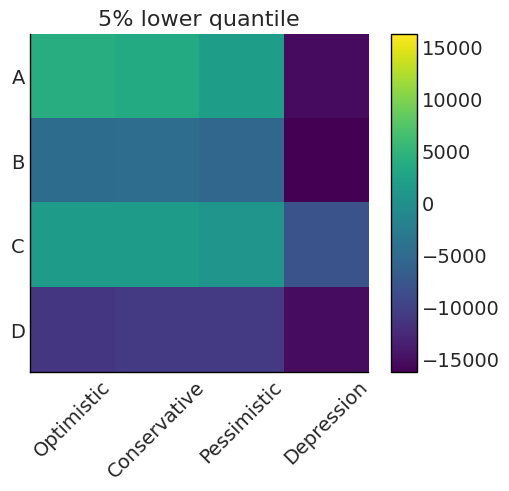

In [22]:
bound = max(np.abs(scenario_quantile.min()), np.abs(scenario_quantile.max()))
plt.imshow(scenario_quantile.T, vmin=-bound, vmax=bound)
plt.title("5% lower quantile");
plt.yticks(*zip(*enumerate(scenario_quantile.coords["exp"].values)))
plt.xticks(*zip(*enumerate(scenario_quantile.coords["scenario"].values)), rotation=45)
plt.colorbar();

Если сравнивать эксперименты по 5%-му квантилю, при первых 3 сценариях предпочтительнее вариант A с прибылью около 1800-4000 дол. На 2-м месте располагается вариант C с прибылью 620-1673 дол. Варианты B и D убыточны при этих сценариях. При депрессивном сценарии все варианты становятся убыточными, но убыток от варианта C примерно в 2 раза меньше, чем в остальных случаях.

В целом наиболее потенциально выгодным является вариант A, но он включает высокие издержки на внедрение. Наименее рисковым с ожидаемой положительной прибылью является вариант C.